- Andrea De Vita
- Enrico Lupi

-----------------------

# Bayesian Blocks Algorithm

In [2]:
suppressPackageStartupMessages(library(tidyverse))
library(tidyverse, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(gridExtra)

## Abstract

The Bayesian Block algorithm exploits a simple non-parametric modeling technique to identify and characterize statistically significant variations, and at the same time suppress the corrupting observational errors. It was originally developed for astronomy applications to detect local variability in time series, but has since found use also in high energy physics as a way to impove the binning of histograms.  

After an introduction on the algorithm, we present its implementation in R and quantitatively compare its performance with other commonly used binning methods. Lastly, we apply it to some real physics distributions from nuclear and subnuclear physics to show its usefulness in real-life scenarios. 


## Table of Content

1. [Introduction](#introduction) <br>
2. [Theory](#theory) <br>
    2.1. [Prior](#theory_prior) <br>
    2.2. [Data Modes](#theory_data) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.1. [Event data](#theory_data_events) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.2. [Binned data](#theory_data_binned) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3. [Point measurements](#theory_data_measurements) <br>
3. [Algorithm](#algorithm) <br>
    3.1. [Algorithm Description](#alg_description) <br>
    3.2. [Code Implementation](#alg_implementation) <br>
    3.3. [Execution Time](#alg_time) <br>
4. [Comparison with Other Binning Methods](#comparison) <br>
    4.1. [Metrics](#comp_metrics) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1.1. [Average Metric](#comp_metrics_wiggles) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1.2. [Average Error Metric](#comp_metrics_avgerror) <br>
    4.2. [Results](#comp_results) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2.1. [Note on the Uniform Prior](#comp_results_uniform) <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2.2. [Custom Distributions](#comp_results_custom) <br>
5. [Applications to Nuclear and Subnuclear Physics](#applications)<br>
    5.1. [Radioactive Source](#app_radio) <br>
    5.2. [CMS Data](#app_cms) <br>
6. [Bibliography](#bibliography) <br>


## 1. Introduction <a name="introduction"></a>

The goal of data analysis is to identify and describe statistically significant variations and features within the observed data. In this pursuit, histograms are a valuable tool for visualizing and examining the data distributions.

It is common practice to select a subjective range and bin width for histograms, often driven by the desire to create visually appealing plots. However, objective approaches have been developed to determine the binning based on optimization procedures like *Scott's Rule*, which is ideal for randomly sampled data following a normal distribution. Certain methods, such as *Freedman-Diaconis Rule*, consider the distribution's structure but employ fixed-width bins. Alternatively, some methods aim for each bin to have a similar number of entries, allowing for variable bin widths while still arbitrarily selecting the location of bin edges.

The Bayesian Blocks algorithm offers a distinct approach by allowing variable bin widths and determining the bin edges based on the underlying distribution's structure. Originally developed by **Jeffrey D. Scargle** for astronomy applications [[1]](#Scargle), the algorithm was designed to detect and characterize local variability in time series data. However, it can also be applied to other sequential or independent variable data. One of its applications is to enhance histogram representations by allowing flexible bin sizes determined by the data.

<div class="alert alert-success" role="alert" style="background-color: #ADD8E6; color: #000080;">
  <h4 class="alert-heading">Baysian blocks algorithm</h4>
  <p>Operating within a Bayesian framework, the Bayesian Blocks algorithm is a <b>non-parametric modeling technique</b> that aims to find the optimal segmentation of a set of univariate random variables into blocks. Each block consists of consecutive data elements that meet a specific criterion.</p>
  <hr>
  <p class="mb-0">The primary objective is to differentiate statistically significant features from random observational errors, thereby uncovering local structures in the background data by utilizing the information inherent in the data itself.</p>
</div>

## 2. Theory <a name="theory"></a>

The Bayesian Blocks algorithm is based on fitting a piecewise constant model to the data. The range of the independent variable is divided into sub-intervals called blocks, generally unequal in size, in which the dependent variable is modeled as constant within errors.  
Defining the $x$s ending one block and starting the next
as change points, the model of the whole observation interval
contains these parameters:

1. $N_{cp}$: the number of change points
2. $X^{cp}_k$: the change-point starting block $k$ (and ending block $k − 1$)
3. $Y_k$: the signal amplitude in block $k$

for $k = 1, 2, . . .N_{cp}-1$. The first and last data are always considered change points and are therefore not free parameters.  
Our simple model for each block has effectively two parameters: the length of the interval spanned by the block, and the signal amplitude, which is treated as a nuisance parameter to be determined after the change points have been located.

Of all possible such “step functions” this approach yields the best one by maximizing some goodness-of-fit measure. The fitness function used varies depending on the data mode we are analyzing (see [Sec. 2.2](#theory_data)). The
algorithm relies on the fitness being block-additive:

$$F[\mathcal{P} \left( \mathcal{T} \right) ] = \sum_{k = 1}^{N_{blocks}} f \left(B_k\right)$$

where $F[\mathcal{P} \left( \mathcal{T} \right) ]$ is the total fitness of the partition $\mathcal{P}$ of interval $\mathcal{T}$ and $f(B_k)$ is the fitness of block $k$. All model parameters are marginalized except for the  block edges.



### 2.1. Prior <a name="theory_prior"></a>

The fitness described above must be modified by a penalty term for the number of blocks. Not assigning an explicit prior probability distribution for the number of blocks amounts to using a flat prior; in most settings, though, it is much more likely a priori that $N_{blocks} \ll N$ than that $N_{blocks} \approx N$.
For this reason, it is desirable to impose a prior that assigns smaller probability to a large number of blocks. 

A possible choice is this *geometric prior* [[6]](#Coram) with a single parameter $\gamma$:

$$P(N_{blocks}) = P_0 \cdot \gamma^{N_{blocks}} = \cfrac{1 - \gamma}{1 - \gamma^{N}} \gamma^{N_{blocks}}$$

for $0 \le N_{blocks} \le N$, and zero otherwise. $P_0$ is the normalization constant, while $\gamma$ can be thought of as a free parameter that controls the factor by which $n$ blocks are favored over $n +1$ blocks. Therefore, values of $\gamma$ larger than 1 almost certainly lead to extreme overfitting.

This prior can be easily implemented in the algorithm: its contribution to block fitness can be obtained simply by adding the constant

$$\text{ncp_prior} = \log \left( \gamma \right)$$

to the fitness of each block. This parameter can be objectively calibrated as a function of the number of data points.  
The procedure uses the fact that this parameter controls the false positive rate $p_1$ — i.e., the probability of falsely reporting detection of a change point - and its complementary quantity $p_0 ≡ 1 − p_1$, the frequency with which the algorithm correctly rejects the presence of a change point. Therefore, $p_0$ is also the probability that a change point reported by the algorithm with this value of $\text{ncp_prior}$ is indeed statistically significant — hence we call it the correct detection rate for single change points. The desired $\text{ncp_prior} – p_0$ relationship is found through the following procedure: generate a synthetic pure noise time series; apply the algorithm for a range of $\text{ncp_prior}$; select the smallest value that yields false detection frequency equal or less than the desired rate, such as $0.05$.

This process gives no exact formulas, but rather fits to the numerical simulations. The results for different types of likelihoods and data modes are given in the following section ([Sec. 2.2](#theory_data)).

### 2.2. Data Modes <a name="theory_data"></a>

The algorithms can be used with a variety of types of data, often called *data modes*.

#### 2.2.1 Event Data <a name="theory_data_events"></a>

For series of times of discrete events it is natural to associate one data cell with each event. The following derivation of the appropriate block fitness will elucidate exactly what information the cells must contain to allow evaluation of the fitness for the full multi-block model.

In practice the event times are integer multiples of some small unit, but it is often convenient to treat them as real numbers on a continuum. For example, the fitness function is easily obtained starting with the unbinned likelihood known as the Cash statistic. If $M\left(t,\theta\right)$ is a model of the time dependence of a signal the unbinned loglikelihood is

$$ \log L \left( \theta \right) = \sum_n \log M\left(t_n,\theta\right) - \int M\left(t,\theta\right)dt$$

where the sum is over the events and $\theta$ represents the model parameters. The integral is calculated over the observation interval and represents the expected number of events according to the model. In our block model, which is constant and has a single parameter, we can define $M\left(t,\lambda\right) = \lambda$. Consequently, for block k, the log-likelihood can be written as:

$$ \log L^{\left(k\right)}\left(\lambda\right)=N^{\left(k\right)}\log\lambda - \lambda T^{\left(k\right)}$$

where $N\left(k\right)$ is the number of events in block k and $T\left(k\right)$ is the length of the block. The maximum of this likelihood is at $\lambda = \frac{N\left(k\right)}{T\left(k\right)}$, yielding

$$ \log L_{max}^{\left( k\right)} + N^{\left(k\right)} = N^{\left(k\right)}\left( \log N^{\left(k\right)} - \log T^{\left(k\right)} \right)$$

The term $N\left(k\right)$ is taken to the left side because its sum over the blocks is a constant (N, the total number of events) that is model-independent and therefore irrelevant. Additionally, note that changing the units of time, e.g., using a scale factor $\alpha$, modifies the log-likelihood by $ −N^{\left(k\right)} log\left(\alpha\right)$. However, this change is also irrelevant due to the same reason.

Interestingly, the actual positions of the independent events within their blocks do not affect the results. The fitness function solely depends on the number of events in the block, disregarding their specific locations or the intervals between them. This outcome directly arises from the nature of the underlying independently distributed or Poisson process.

The simulations for the calibration of $\text{ncp_prior}$ were successfully fitted to the following formula:

$$ \text{ncp_prior} = 4 -\log \left(73.53p_0N^{-0.478} \right)$$

#### 2.2.2 Binned Data <a name="theory_data_binned"></a>

The expected count in a bin is calculated as the product of three factors: the true event rate at the detector ($\lambda$), a dimensionless exposure factor ($e$), and the width of the bin ($W$). Therefore, the likelihood for bin $n$ follows a Poisson distribution:

$$L_n=\frac{\left(\lambda e_n W_n\right)^{N_n}e^{-\lambda e_n W_n}}{N_n!}$$

In this equation, $N_n$ represents the number of events in bin $n$, $\lambda$ is the actual event rate in PDF per unit time, $e_n$ is the exposure averaged over the bin, and $W_n$ is the bin width in time units. The likelihood for block $k$ is the product of the likelihoods of all its bins:

$$ L^{\left( k \right)} \prod^{M^{\left( k \right)}}_{n=1} L_n = \lambda^{N^{\left( k \right)}}e^{-ew^{\left( k \right)}}$$

Here, $M^{\left(k\right)}$ represents the number of bins in block $k$, and $w^{\left( k \right)}$ is the sum of the bin efficiencies in the block, given by $\sum^{M^{\left( k \right)}}_{n=1}w_n$. Additionally, $N^{\left( k \right)}$ is the total event count in the block, represented by $\sum^{M^{\left( k \right)}}_{n=1}N_n$.

The factor $\frac{\left(e_n W_n\right)^{N_n}}{N_n!}$ has been discarded because its product over all the bins in all the blocks is a constant (depending on the data only) and therefore irrelevant to model fitness. The log-likelihood is

$$ \log L^{\left( k\right)} = N^{\left(k\right)}\log \lambda- \lambda w^{\left( k \right)}$$

This log-likelihood is identical to that of event data, where $w^{\left( k \right)}$ plays the role of $T^{\left(k\right)}$, acting as an effective block duration.

It is worth noting that unbinned and binned event data share the same fitness function, with the main difference being that each bin of binned data can contain multiple events. To account for this, a weight parameter can be assigned to each bin, with a value of one when considering unbinned data.

Simulations show that for binned data, the optimal $\text{ncp_prior}$ is not very sensitive to $p_0$.

#### 2.2.3 Point Measurements <a name="theory_data_measurements"></a>

An often encountered experimental setup involves the measurement of a signal, denoted as $s(t)$, at a series of time instances $t_n \,\,\, n = 1,2,...,N$, with the aim of understanding its temporal behavior. 

The observation times $t_n$ collectively form the sampling, which can be selected arbitrarily, either as evenly spaced points or in a different manner. Additionally, we explicitly assume that the measurements taken at these times are statistically independent of one another, meaning that the observation errors are independent.

The observational error at a specific time $t_n$ is characterized solely by its statistical distribution. Let's consider the case where the errors follow a normal probability distribution with a mean of zero and a given variance. If the model signal is a constant value $s = \lambda$, the likelihood of obtaining measurement $n$ is given by:

$$ L_n = \frac{1}{\sigma_n \sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x_n-\lambda}{\sigma_n}\right)^2}$$

As we assume independence among the measurements, the likelihood for block $k$ can be expressed as the product of individual likelihoods:

$$ L^{\left( k \right)} = \prod_n L_n$$

where $n$ represents the indices corresponding to the times $t_n$ falling within block $k$.

The maximum value of the log-likelihood corresponding to block $k$ is the following:

$$\log L^{\left(k\right)}_{max} =-\frac{1}{2}\left[ 2c_k-\frac{b_k^2}{2a_k}\right]$$

Here, the terms $a_k$, $b_k$, and $c_k$ are defined as:

$$ a_k = \frac{1}{2}\sum_n\frac{1}{\sigma^2_n}$$
$$ b_k =-\sum_n\frac{x_n}{\sigma^2_n}$$
$$ c_k =\frac{1}{2}\sum_n\frac{x_n^2}{\sigma^2_n}$$

By neglecting the first term, which is quadratic in $x$ and sums to a constant independent of the model, we arrive at the simplified expression:

$$\log L^{\left(k\right)}_{max} =\frac{b_k^2}{4a_k}$$

The simulations for the calibration of $\text{ncp_prior}$ were successfully fitted to the following formula:

$$\text{ncp_prior} = 1.32 + 0.577\cdot\text{log}\left(N\right)$$

Importantly, this relationship remains unaffected by the signal-to-noise ratio in the simulations.

## 2. Algorithm <a name="algorithm"></a>

### 2.1. Algorithm Description <a name="alg_description"></a>

We will follow a **dynamic programming** approach. Beginning with the first data cell, at each step one more cell is added using the results of the previous steps: the value of optimal fitness is stored in the array *best* and the location of the last change point in the array *last*.

Let $\mathcal{P}^{opt}(R)$ denote the optimal partition of the first $R$ cells. In the starting case $R = 1$, the only possible partition (one block consisting of the first cell by itself) is trivially optimal. Now assume we have completed step $R$: it remains to show how to obtain $\mathcal{P}^{opt}(R+1)$.  
For some $r$ consider the set of all partitions (of these first $R+1$ cells) whose last block starts with cell $r$ (and by definition ends at $R + 1$) and denote the fitness of this last block by $F(r)$. The only member of this set that could possibly be optimal is that consisting of $\mathcal{P}^{opt}(r-1)$ followed by this last block. By the additivity of the Likelihood the fitness of said partition is the sum of $F(r)$ and the fitness of $\mathcal{P}^{opt}(r-1)$ (saved from a previous step in *best*):

$$ 
A(r) = F(r) + 
\begin{cases}
    0, & r = 1\\
    best(r - 1), & r = 2, 3, . . . , R + 1
\end{cases}
$$

The value of $r$ yielding the optimal partition $\mathcal{P}^{opt}(R+1)$ is the value maximizing $A(r)$:

$$
r^{opt} = argmax[A(r)]
$$


At the end of this computation, when $R = N$, it only remains to find the locations of the change points of the optimal partition. The needed information is contained in the array *last*: we use the last value in this array to determine the last change point in $\mathcal{P}^{opt}(N)$, peel off the end section of last corresponding to this last block, and repeat:

$$
\begin{align}
cp_1 & = last(N) \\
cp_2 & = last(cp_1 − 1) \\
cp_3 & = last(cp_2 − 1) \\
     & ...
\end{align}
$$

### 2.2. Code Implementation <a name="alg_implementation"></a>

Here is the R code implementing the algorithm:

In [4]:
bayesian_blocks <- function(data,
                            weights = NULL,
                            sigma = NULL,
                            Data_mode = "Event Data",
                            Prior = "calibrated",
                            p0 = 0.05,
                            gamma = NULL) {
    # Bayesian Blocks Implementation.

    # This is a flexible implementation of the Bayesian Blocks algorithm for 1 dimension.

    # Args:
    #   data: Input data values (one dimensional, length N). Repeat values are allowed.

    #   weights: Weights for data (otherwise assume all data points have a weight of 1),
    #            or measured values in case of Point Measurements
    #            Must be same length as data. Defaults to NULL.
    
    #   sigma: array or float representing the error of the measurement in case of
    #          Point Measurements. Defaults to NULL.
    
    #   Data_mode: accepted values are "Event Data", "Binned Data" and "Point Measurements",
    #              though the first two are functionally identical. Defaults to "Event Data".

    #   prior: Prior on the number of blocks. Options include a uniform prior, a gemetric prior that
    #          penalizes an excessive number of blocks and a calibrated prior in order to achieve the
    #          specified false-positive rate p0. Deafults to the calibrated one. 

    #   p0: False-positive rate, between 0 and 1. A lower number places a stricter penalty
    #       against creating more bin edges, thus reducing the potential for false-positive bin edges. In general,
    #       the larger the number of bins, the small the p0 should be to prevent the creation of spurious, jagged
    #       bins. Defaults to 0.05.

    #   gamma: If specified, can use this gamma to compute the general prior form,
    #          p = gamma^N. Defaults to NULL.

    # Returns:
    #   Array containing the (N+1) bin edges

    # Examples:
    #   Unweighted data:

    #   >>> d <- rnorm(n=100)
    #   >>> bins <- bayesian_blocks(d, p0=0.01)

    #   Unweighted data with repeats:

    #   >>> d <- rnorm(n=100)
    #   >>> d[81:100] <- d[1:20]
    #   >>> bins <- bayesian_blocks(d, p0=0.01)

    #   Weighted data:

    #   >>> d <- rnorm(n=100)
    #   >>> w <- runif(n=100, min=1, max=2)
    #   >>> bins <- bayesian_blocks(d, w, p0=0.01)
    
    #   Point Measurements:
    
    #   >>> t = 100 * runif(100)
    #   >>> x = exp(-0.5 * (t - 50) ** 2)
    #   >>> sigma = 0.1
    #   >>> x_obs = rnorm(x, sigma)
    #   >>> edges = bayesian_blocks(t, x_obs, sigma, Data_mode="Point Measurements")

    
    # validate input data
    data <- as.vector(data)

    # validate input weights
    if (!is.null(weights)) {
        weights <- as.vector(weights)
    }
    else {
        # set them to 1 if not given
        weights <- rep(1, length(data))
    }

    if (Data_mode == "Event Data" | Data_mode == "Binned Data") {
        # Place data and weights into a DataFrame.
        # We want to sort the data array (without losing the associated weights), and combine duplicate
        # data points by summing their weights together.
        df <- data.frame(data = data, weights = weights) |>
              group_by(data) |>
              summarise(sum_w = sum(weights))
        data <- pull(df, data)
        weights <- pull(df, sum_w)
    }
    
    N = length(data)


    # create length-(N + 1) array of cell edges
    edges <- c(data[1], 0.5 * (data[1:(N-1)] + data[2:N]), data[N])
    block_length = data[N] - edges


    # arrays to store the best configuration
    best <- rep(0, N)
    last <- rep(0, N)


    # compute prior
    prior <- switch(Prior, 
                    "uniform" = 0,
                    "gamma" = -log(gamma),
                    "calibrated" = 4 - log(73.53 * p0 * N**(-0.478)),
                    0 # default case
             )
    
    
    # initialize vectors for likelihood computation
    # in point measurements data mode
    if (Data_mode == "Point Measurements") {
        ak_raw = rep(1, N) / sigma**2
        bk_raw = weights / sigma**2
    }


    # -----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    # -----------------------------------------------------------------
    
    for (R in 1:N) {
        # Compute fit_vec : fitness of putative last block (ends at data cell R/edge R+1)
        fit_vec <- NULL
        if (Data_mode == "Event Data" | Data_mode == "Binned Data") {
            # T_k: width/duration of each block
            T_k <- block_length[1:R] - block_length[R+1]

            # N_k: number of elements in each block
            N_k <- rev(cumsum(rev(weights[1:R])))

            # evaluate fitness function using Cash statistics
            fit_vec <- N_k * log(N_k / T_k)
        }
        else if (Data_mode == "Point Measurements") {
            # compute a_k and b_k
            a_k <- 0.5 * rev(cumsum(rev(ak_raw[1:R])))
            b_k <- -rev(cumsum(rev(bk_raw[1:R])))
            
            # evaluate fitness function
            fit_vec <- b_k * b_k / (4 * a_k)
        }

        # penalize function with prior
        A_R <- fit_vec - prior
        if (R > 1) {
            A_R[2:R] <- A_R[2:R] + best[1:(R-1)]
        }
        i_max = which.max(A_R)
        last[R] = i_max
        best[R] = A_R[i_max]
    }

    # -----------------------------------------------------------------
    # Now find changepoints by iteratively peeling off the last block
    # -----------------------------------------------------------------

    change_points = rep(0, N+1)
    i_cp = N + 1
    ind = N + 1
    repeat {
        change_points[i_cp] <- ind
        if (ind == 1) {
            break
        }
        ind <- last[ind-1]
        i_cp <- i_cp - 1
    }
    change_points = change_points[i_cp:(N+1)]

    return(edges[change_points])
}

### 2.1 Execution Time <a name="alg_time"></a>

The total number of possible partitions (i.e., the number of ways N cells can be arranged in blocks) is $2^N$, rendering an explicit exhaustive search of partition space impossible in the general case. This algorithm, instead, is able to find the optimal partition in time of order $O(N^2)$, and is practical even for $N ∼ 1,000,000$, for which approximately $10^{300,000}$ partitions are possible.  

We will verify this scaling law by computing the execution time of the algorithm over datasets of increasing size over different order of magnitude. For simplicity, the data is generated form a Normal distribution ${\mathcal {N}}(0, 1)$.

In [3]:
# Test execution time
compute_time <- Vectorize(function(N, func, time_unit = "sec", seed = 48) {
    # create dummy dataset
    set.seed(seed)
    data <- rnorm(N, mean = 0, sd = 1)

    # start clock
    start <- Sys.time()

    func(data)

    # end clock
    end <- Sys.time()
    exec_time <- as.numeric(difftime(end, start, units = time_unit))
    return(exec_time)
}, vectorize.args = "N") 


# Compute execution time over different ranges
N1 <- c(1e2, 1e3, 2e3, 3e3, 4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 1e4)
N2 <- c(1e3, round(sqrt(1e7)), 1e4, round(sqrt(1e9)), 1e5)

exec_time1 <- compute_time(N1, bayesian_blocks)
exec_time2 <- compute_time(N2, bayesian_blocks)

In [4]:
# Quadratic model fit
data_fit1 <- data.frame(x = N1, x2 = N1**2, y = exec_time1)
data_fit2 <- data.frame(x = N2, x2 = N2**2, y = exec_time2)

fit1 <- lm(formula = y ~ x + x2, data = data_fit1)
fit2 <- lm(formula = y ~ x + x2, data = data_fit2)

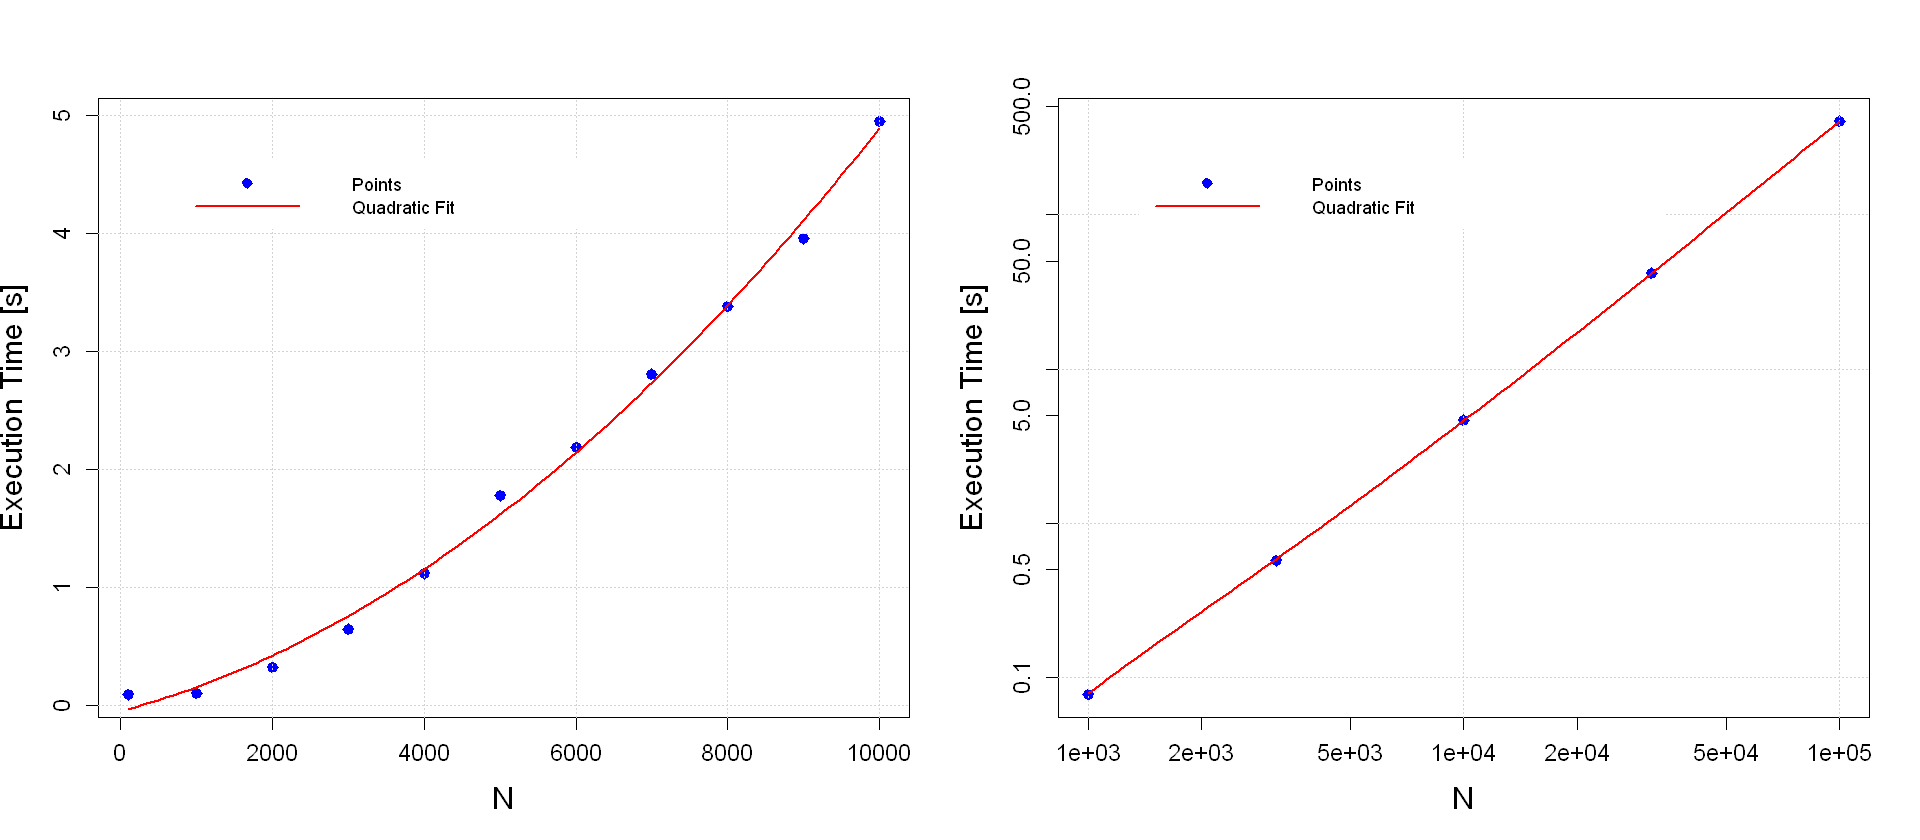

In [5]:
# plot results

fitted_func <- function(fit, x) {
    res <- as.numeric(fit$coefficients["(Intercept)"]) +
           as.numeric(fit$coefficients["x"]) * x +
           as.numeric(fit$coefficients["x2"]) * x**2
    return(res)
}

par(mfrow = c(1, 2))
options(repr.plot.width = 16, repr.plot.height = 7)

plot(N1, exec_time1, xlab = "N", ylab = "Execution Time [s]", col = "blue", pch = 10, lwd = 3,
     cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
grid()
curve(fitted_func(fit1, x), N1[1], tail(N1, 1),
      col = "red", lw = 2, add = T)
legend("topleft", inset=+0.1, legend = c("Points", "Quadratic Fit"),
       col = c("blue","red"), lty = c(NA, 1), pch = c(10, NA), lwd = c(3, 2),
       cex = 0.9, box.lty = 0, border = F)

plot(N2, exec_time2, xlab = "N", ylab = "Execution Time [s]", col = "blue", pch = 10, lwd = 3, log = "xy",
     cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
grid()
curve(fitted_func(fit2, x), N2[1], tail(N2, 1),
      col = "red", lw = 2, add = T)
legend("topleft", inset=+0.1, legend = c("Points", "Quadratic Fit"),
       col = c("blue","red"), lty = c(NA, 1), pch = c(10, NA), lwd = c(3, 2),
       cex = 0.9, box.lty = 0, border = F)

As expected, the data points follow a quadratic distribution quite nicely, with very slight deviations at lower $N$ for linear and constant effects.

## 3. Comparison with Other Binning Methods <a name="comparison"></a>

Other objective methods have been proposed to determine binning according to some optimization procedure.
We will now compare the Bayesian Block algorithm with the following:

- Square root: $K = \lceil \sqrt{N} \, \rceil$
- Scott: $h = \frac{\hat{\sigma}}{N^{1/2}}$, where $\hat{\sigma}$ is the standard deviation of the data [[3]](#Scott) 
- Sturges: $K = \lceil ln(N) \rceil + 1$  [[4]](#Sturges)
- Freedman-Diaconis: $h = 2 \frac{IQRi}{N^{1/3}}$, where $IQR$ is the interquartile range of the data  [[5]](#FreedmanDiaconis)

where $K$ is the number of bins and $h$ is their width.

### 3.1. Metrics <a name="comp_metrics"></a>

In order to quantitavely compare different methods we will use two metrics, introduced by **Pollack**. [[2]](#Pollack)


#### 3.1.1. Wiggles Metric <a name="comp_metrics_wiggle"></a>

This metric is designed to capture the visual appeal of the histogram by minimizing the number of bin-to-bin height fluctuations, hereafter referred to as "wiggles", that denote unwanted statistical fluctuations. The number of wiggles in a histogram is defined as:

$$ W_n = \sum \left[ sgn \left( f'\left(B_i \right) \right) \cdot sgn \left( f'\left(B_{i+1} \right) \right) = -1 \right]$$

where $f'\left(B_i \right)$ is the finite first derivative of the function describing the height of block (or bin) $i$.

This metric simply PDF the number of adjacent opposite-sign first derivatives and increases whene there are many fluctuations in height form one to another.


In [11]:
Wiggle <- function(data, breaks, numBlock) {
    histogram <- hist(data, breaks = breaks, plot = FALSE)

    bin_counts <- histogram$counts
    post_Wiggling <- bin_counts[numBlock+1] - bin_counts[numBlock]
    return(post_Wiggling)
}


Wiggle_metric <- function(data, breaks) {
  
    # Wiggle metric Implementation.
    #
    # Args:
    #   data: Input data values (one dimensional, length N). Repeat values are allowed.
    #
    #   breaks: Sequence of change points or bin edges fro the input data
    #
    # Returns:
    #   W_n, the metric computation
    #
  
    numBlocks <- length(breaks) - 1
  
    W_n <- 0
    for (i in 1:(numBlocks-2)) {
        f.prime_B1 <- Wiggle(data, breaks, i)
        f.prime_B2 <- Wiggle(data, breaks, i+1)
    
        prod <- sign(f.prime_B1)*sign(f.prime_B2)
        if (prod < 0) {
            W_n <- W_n + 1
        }
      }
  return(W_n)
}


#### 3.1.2. Average Error Metric <a name="comp_metrics_avgerror"></a>

This metric measures the accuracy of a given histogram in reconstructing the underlying pdf, while minimizing the impact of statistical fluctuations due to the initial data used to generate the histogram.

Consider a dataset that consists of N independent events such that $D = \{ d_i\}_{i=1,...,N}$. From it construct a histogram which allows to generate a new dataset $\hat{D}$, where each point is generated by a linear interpolation of each bin. This can be done by considering each bin $i$ and extracting for each of them $n_i$ equally spaced points, where $n_i$ is equal to the height of the bin. Thus $\hat{D}$ is equal in size to the original data, but evenly distributed within each respective bin.

Then one can compare the interpolated dataset with M different independent datasets, all of which are derived from the original distribution and have size N. We can use these datasets to construct the average metric error, defined as:

$$ \hat{E} = \frac{1}{M}\sum^M_{m=1} \left(\sum^N_{n=1} |d_{nm}-\hat{d}_n|\right) $$

where $d_{nm}$ is the n-th data point from the m-th data set.

This metric typically decreases as the size of the bins decreases, but in general does not approach 0 as the bins become infinitesimally narrow. The metric penalizes a histogram for modeling the statistical fluctuations of a given distribution by comparing the interpolated data with statistically independent datasets and not the dataset used to generate the histogram.

In [12]:
Average_metric <- function(data, breaks, distribution, M = 20, ...) {

    # Average_metric Implementation.
    #
    # Args:
    #   data: Input data values (one dimensional, length N). Repeat values are allowed.
    #
    #   breaks: Sequence of change points or bin edges fro the input data
    #
    #   distribution: underlying distributionused to generate toy dataset
    #
    #   M: number of independent toy dataset generated
    #
    #   ...: arguments to generate underlying distribution
    #
    # Returns:
    #   E_hat
    #
  
    histogram <- hist(data, breaks = breaks, plot = FALSE)
  
    numBlocks <- length(breaks)-1
    bin_counts <- histogram$counts
    
    hat_data <- c()
    for (i in 1:numBlocks) {
        points <- seq(breaks[i], breaks[i+1], length.out=bin_counts[i])
        hat_data <- c(hat_data, points)
    }
  
    N <- length(data)
    Mdata <- matrix(nrow = N, ncol = M)
  
    for(i in 1:M) {
        Mdata[,i] <- sort(distribution(N, ...))
    }
  
    E_hat <- 0
    for (m in 1:M) {
        for(n in 1:N) {
            E_hat <- E_hat + abs(Mdata[n,m] - hat_data[n])
        }
    }
  
    E_hat <- E_hat/M
  
    return(E_hat)
}

### 3.2. Results <a name="comp_results"></a>

#### 3.2.1. Note on the Uniform Prior <a name="comp_results_uniform"></a>

In the following analysis we will not show the Bayesian Blocks algorithm using a uniform prior. In fact, since the result is not penalised for a high number of blocks, it always leads to extreme overfitting, so that the final result is nonsensical.

As an example, here is the result of the algorithm on a Normal distribution ${\mathcal {N}}(0, 1)$:

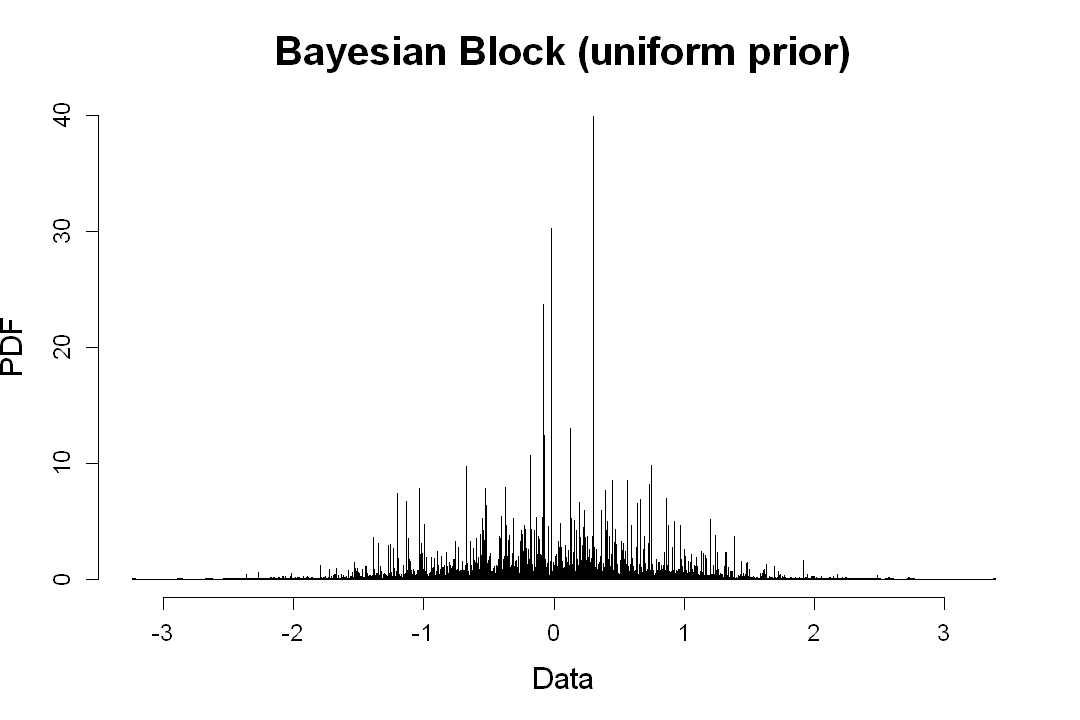

In [8]:
data <- rnorm(5000)
uniform_breaks <- bayesian_blocks(data, Prior="uniform")

# plot results
options(repr.plot.width = 9, repr.plot.height=6)
hist(data, breaks = uniform_breaks, col = "lightblue", border = "black",
     xlab = "Data", ylab = "PDF", main = sprintf("Bayesian Block (uniform prior)"),
     cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)

#### 3.2.2. Custom Distributions <a name="comp_results_custom"></a>

We will compare the binning methods on different ad-hoc distributions: 

- The first one has three gaussian peaks over a uniform background, with the two left peaks slightly overlapping
- The second one has a gaussian peak over an exponential background

In [6]:
# 3 gaussian peaks over uniform background
three_peaks <- function(N) {
    u <- runif(N)
    data <- ifelse(u < 8/15, rnorm(N, 500, 30),
                             ifelse(u < 0.7, runif(N, 0, 1500),
                                             ifelse(u < 13/15, rnorm(N, 1000, 50),
                                                               rnorm(N, 425, 20))))
    return(data)
}

# gaussian peak over exponential background
one_peak_exp_bkg <- function(N) {
    u <- runif(N)
    data <- ifelse(u < 0.85, rexp(N, 0.2),
                             rnorm(N, 9, 1))
    return(data)
}

In [7]:
compute_breaks <- function(data, plot_results = TRUE) {
    
    # compute histograms breaks for the 6 methods
    breaks_BB_cal   = bayesian_blocks(data, Prior="calibrated", p0 = 0.05)
    breaks_BB_gamma = bayesian_blocks(data, Prior="gamma", gamma = 0.006)
    breaks_fd       = hist(data, breaks = "freedman-diaconis", plot = FALSE)$breaks
    breaks_scott    = hist(data, breaks = "scott",             plot = FALSE)$breaks
    breaks_sqrt     = seq(min(data), max(data), length.out=round(sqrt(length(data)))+1)
    breaks_sturges  = hist(data, breaks = "sturges",           plot = FALSE)$breaks

    break_list <- list(breaks_BB_cal, breaks_BB_gamma, breaks_sqrt,
                       breaks_scott, breaks_sturges, breaks_fd)
    names(break_list) <- c("BB_cal", "BB_gamma", "Sqrt", "Scott", "Sturges", "FD")

    
    if (plot_results) {
        # plot results
        par(mfrow = c(2, 3))
        options(repr.plot.width = 20, repr.plot.height=10)

        hist(data, breaks = breaks_BB_cal, col = "lightblue", border = "black",
             xlab = "Data", ylab = "PDF", main = sprintf("Bayesian Block (calibrated prior)"),
             cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
        hist(data, breaks = breaks_BB_gamma, col = "salmon", border = "black",
             xlab = "Data", ylab = "PDF", main = sprintf("Bayesian Block (gamma=0.06 prior)"),
             cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
        hist(data, breaks=breaks_fd, col = "yellow", border = "black", freq = FALSE,
             xlab = "Data", ylab = "PDF", main = sprintf("Freedman-Diaconis"),
             cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
        hist(data, breaks = breaks_scott, col = "pink", border = "black", freq = FALSE,
             xlab = "Data", ylab = "PDF", main = sprintf("Scott"),
             cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
        hist(data, breaks = breaks_sqrt, col = "palegreen", border = "black", freq = FALSE,
             xlab = "Data", ylab = "PDF", main = sprintf("Sqrt"),
             cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
        hist(data, breaks = breaks_sturges, col = "plum3", border = "black", freq = FALSE,
             xlab = "Data", ylab = "PDF", main = sprintf("Sturges"),
             cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
    }
    
    return(break_list)
}

In [9]:
scores <- function(data, break_list, distribution, M = 500, plot_results = TRUE, ...) {
    
    methods <- names(break_list)
  
    ##scores
    columns <- c("Method", "W", "E")
    scores <- data.frame(matrix(nrow = 0, ncol = length(columns))) 
    colnames(scores)[1:3] <- columns
  
    for (met in methods) {
        W <- Wiggle_metric(data, unlist(break_list[met]))
        E <- Average_metric(data, unlist(break_list[met]), distribution, M, ...)
        scores[nrow(scores) + 1,] <- c(met, W, E)
    }
  
    scores$W <- as.numeric(scores$W)
    scores$E <- as.numeric(scores$E)
  
    ##ranks
    ranks <- data.frame(Method = methods,
                        W = floor(rank((scores$W))),
                        E = floor(rank((scores$E))))
  
    long_ranks <- pivot_longer(ranks, -c(Method), names_to = "Metric")
  
    if (plot_results) {
        # plot results
        options(repr.plot.width = 20, repr.plot.height = 6)
        score_plot <- ggplot(scores) +
                      geom_point(aes(x = E, y = W, fill = Method, shape = Method), size = 7, color = "black") +
                      theme_bw(base_size = 22) +
                      scale_fill_manual(values = c("lightblue","salmon", "yellow", "pink", "palegreen", "plum3")) +
                      scale_shape_manual(values = c(23, 23, 21, 21, 21, 21)) +
                      labs(x = "E  (Average Errror metric)",
                           y = "W  (Wiggle metric)")
  
        rank_plot <- ggplot(long_ranks, aes(x = Method, y = value, fill = Metric)) +
                     theme_bw(base_size = 22) +
                     geom_col(position = "stack")+
                     labs(x = "Method", y = "Rank")
  
        grid.arrange(score_plot, rank_plot, ncol = 2, nrow=1)
    }
  
    return(list(score=scores,rank=ranks))
}

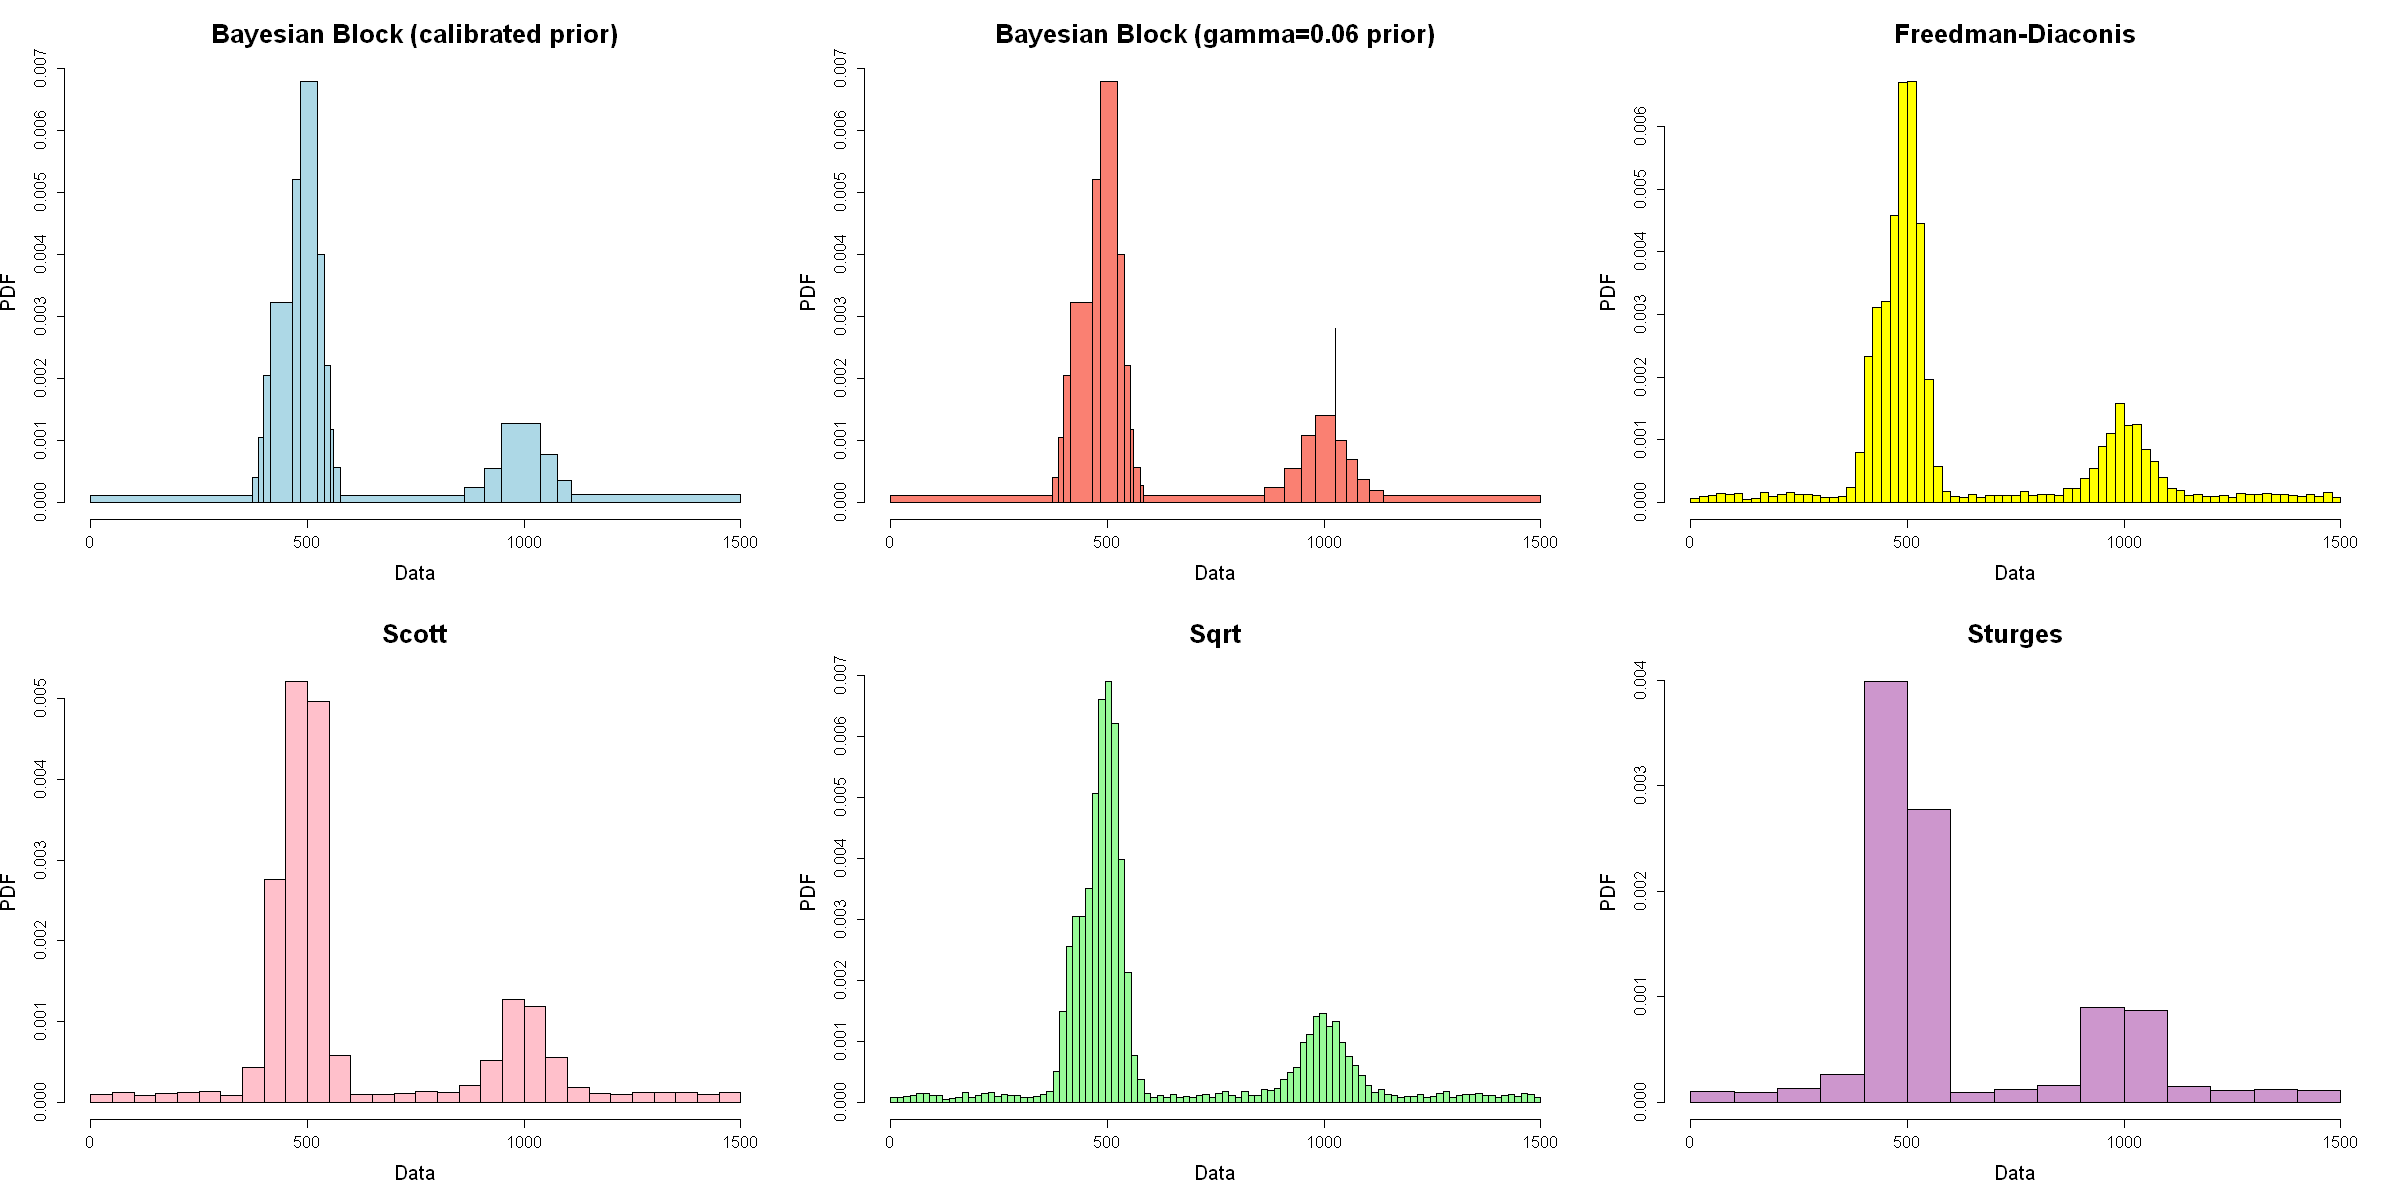

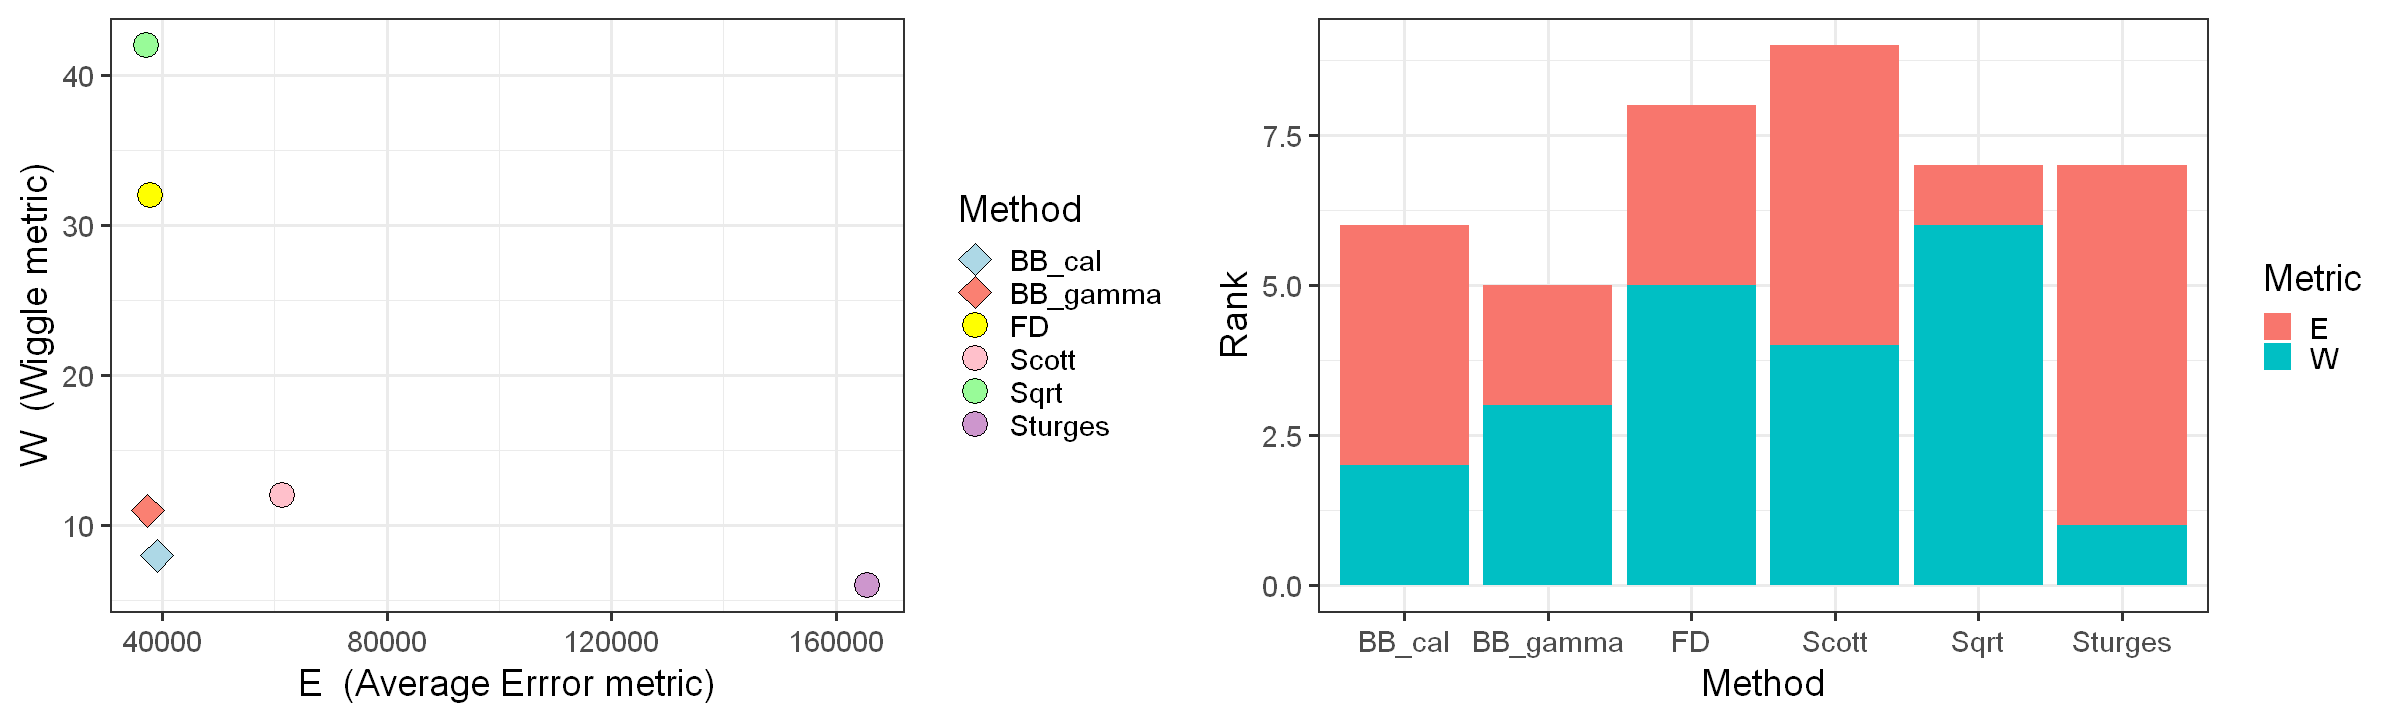

In [13]:
set.seed(12)
data1 <- three_peaks(10000)
break_list1 <- compute_breaks(data1)
scores1 <- scores(data1, break_list1, three_peaks, M = 1000)

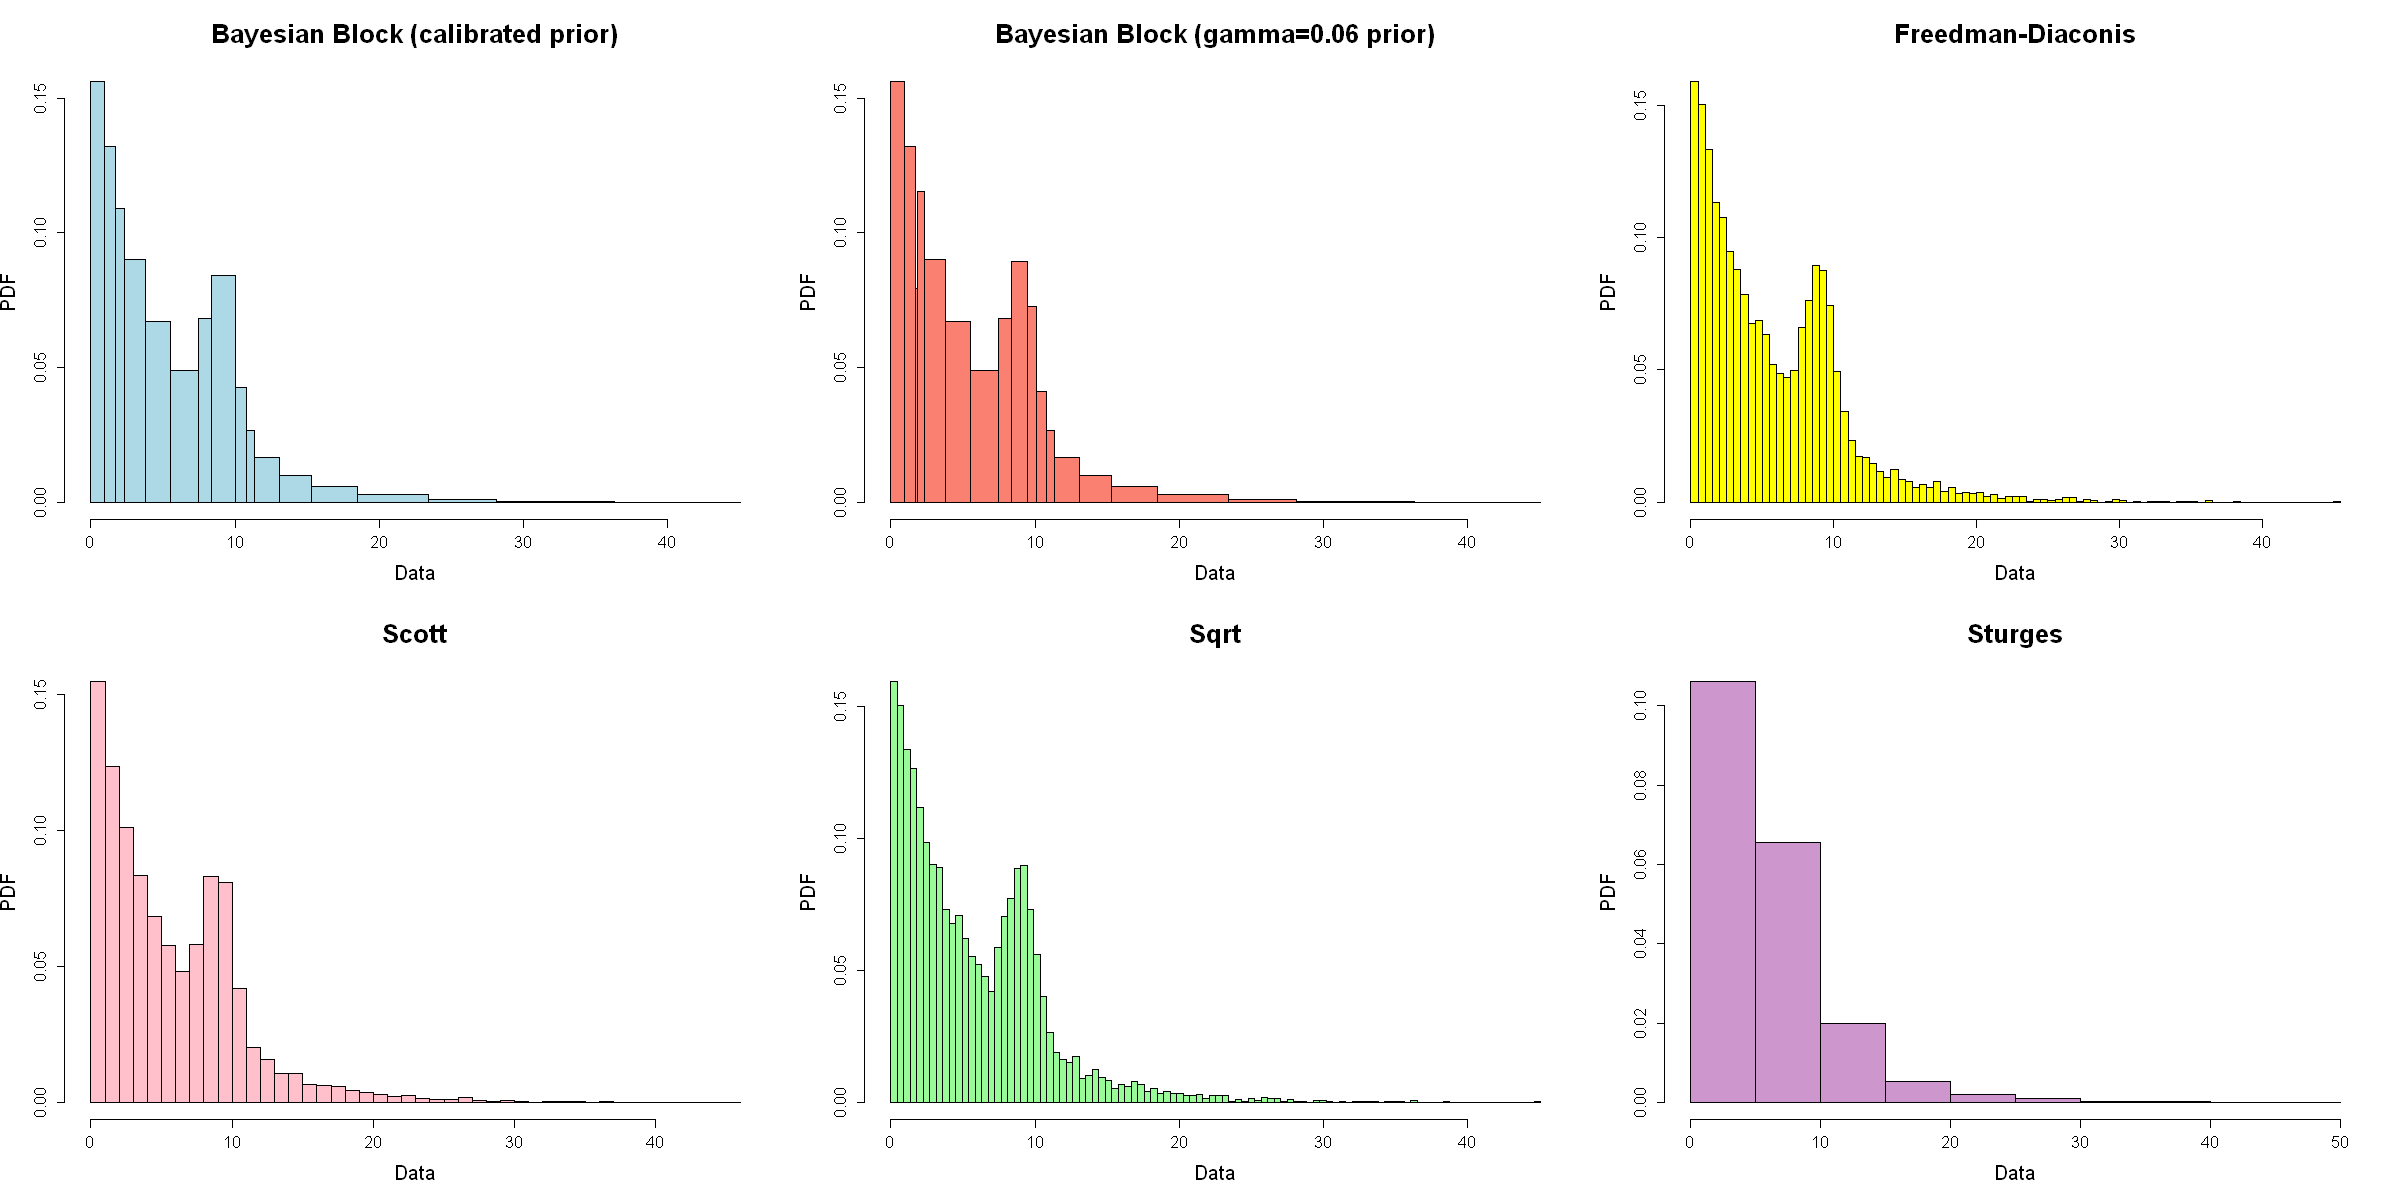

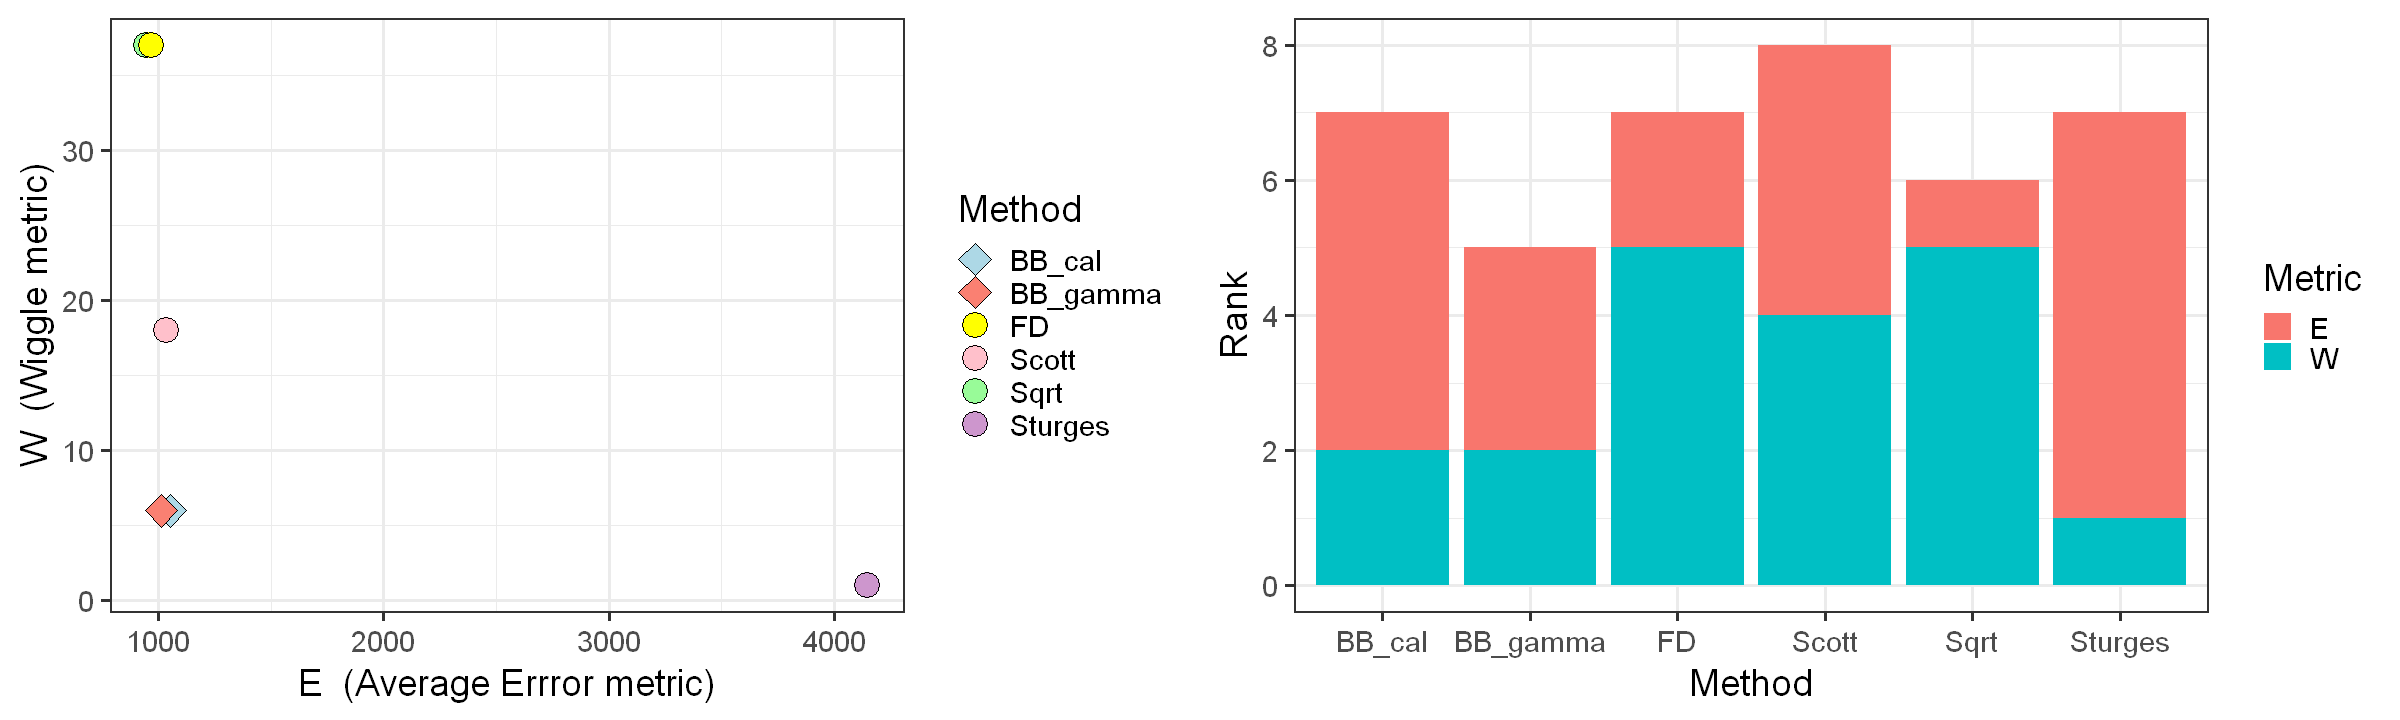

In [21]:
set.seed(12)
data2 <- one_peak_exp_bkg(10000)
break_list2 <- compute_breaks(data2)
sscores2 <- scores(data2, break_list2, one_peak_exp_bkg, M = 1000)

## 4. Applications to Nuclear and Subnuclear Physics  <a name="applications"></a>

### 4.1. Radioactive Source <a name="app_radio"></a>

We will apply the algorithm to energy spectra measured by a $LaBr_3$ scintillator detector at INFN Legnaro laboratories. The following raioactive sources will be studied:

- Cobalt-60
- Cesium-137
- Sodium-22

In [18]:
# load dataset
Co <- read_tsv("Data/Co10cm.txt", show_col_types = FALSE) |> filter(Energy < 1700) |> pull("Energy")
Cs <- read_tsv("Data/Cs10cm.txt", show_col_types = FALSE) |> filter(Energy < 1700) |> pull("Energy")
Na <- read_tsv("Data/Na10cm.txt", show_col_types = FALSE) |> filter(Energy < 1700) |> pull("Energy")

breaks_Co <- bayesian_blocks(Co)
breaks_Cs <- bayesian_blocks(Cs)
breaks_Na <- bayesian_blocks(Na)

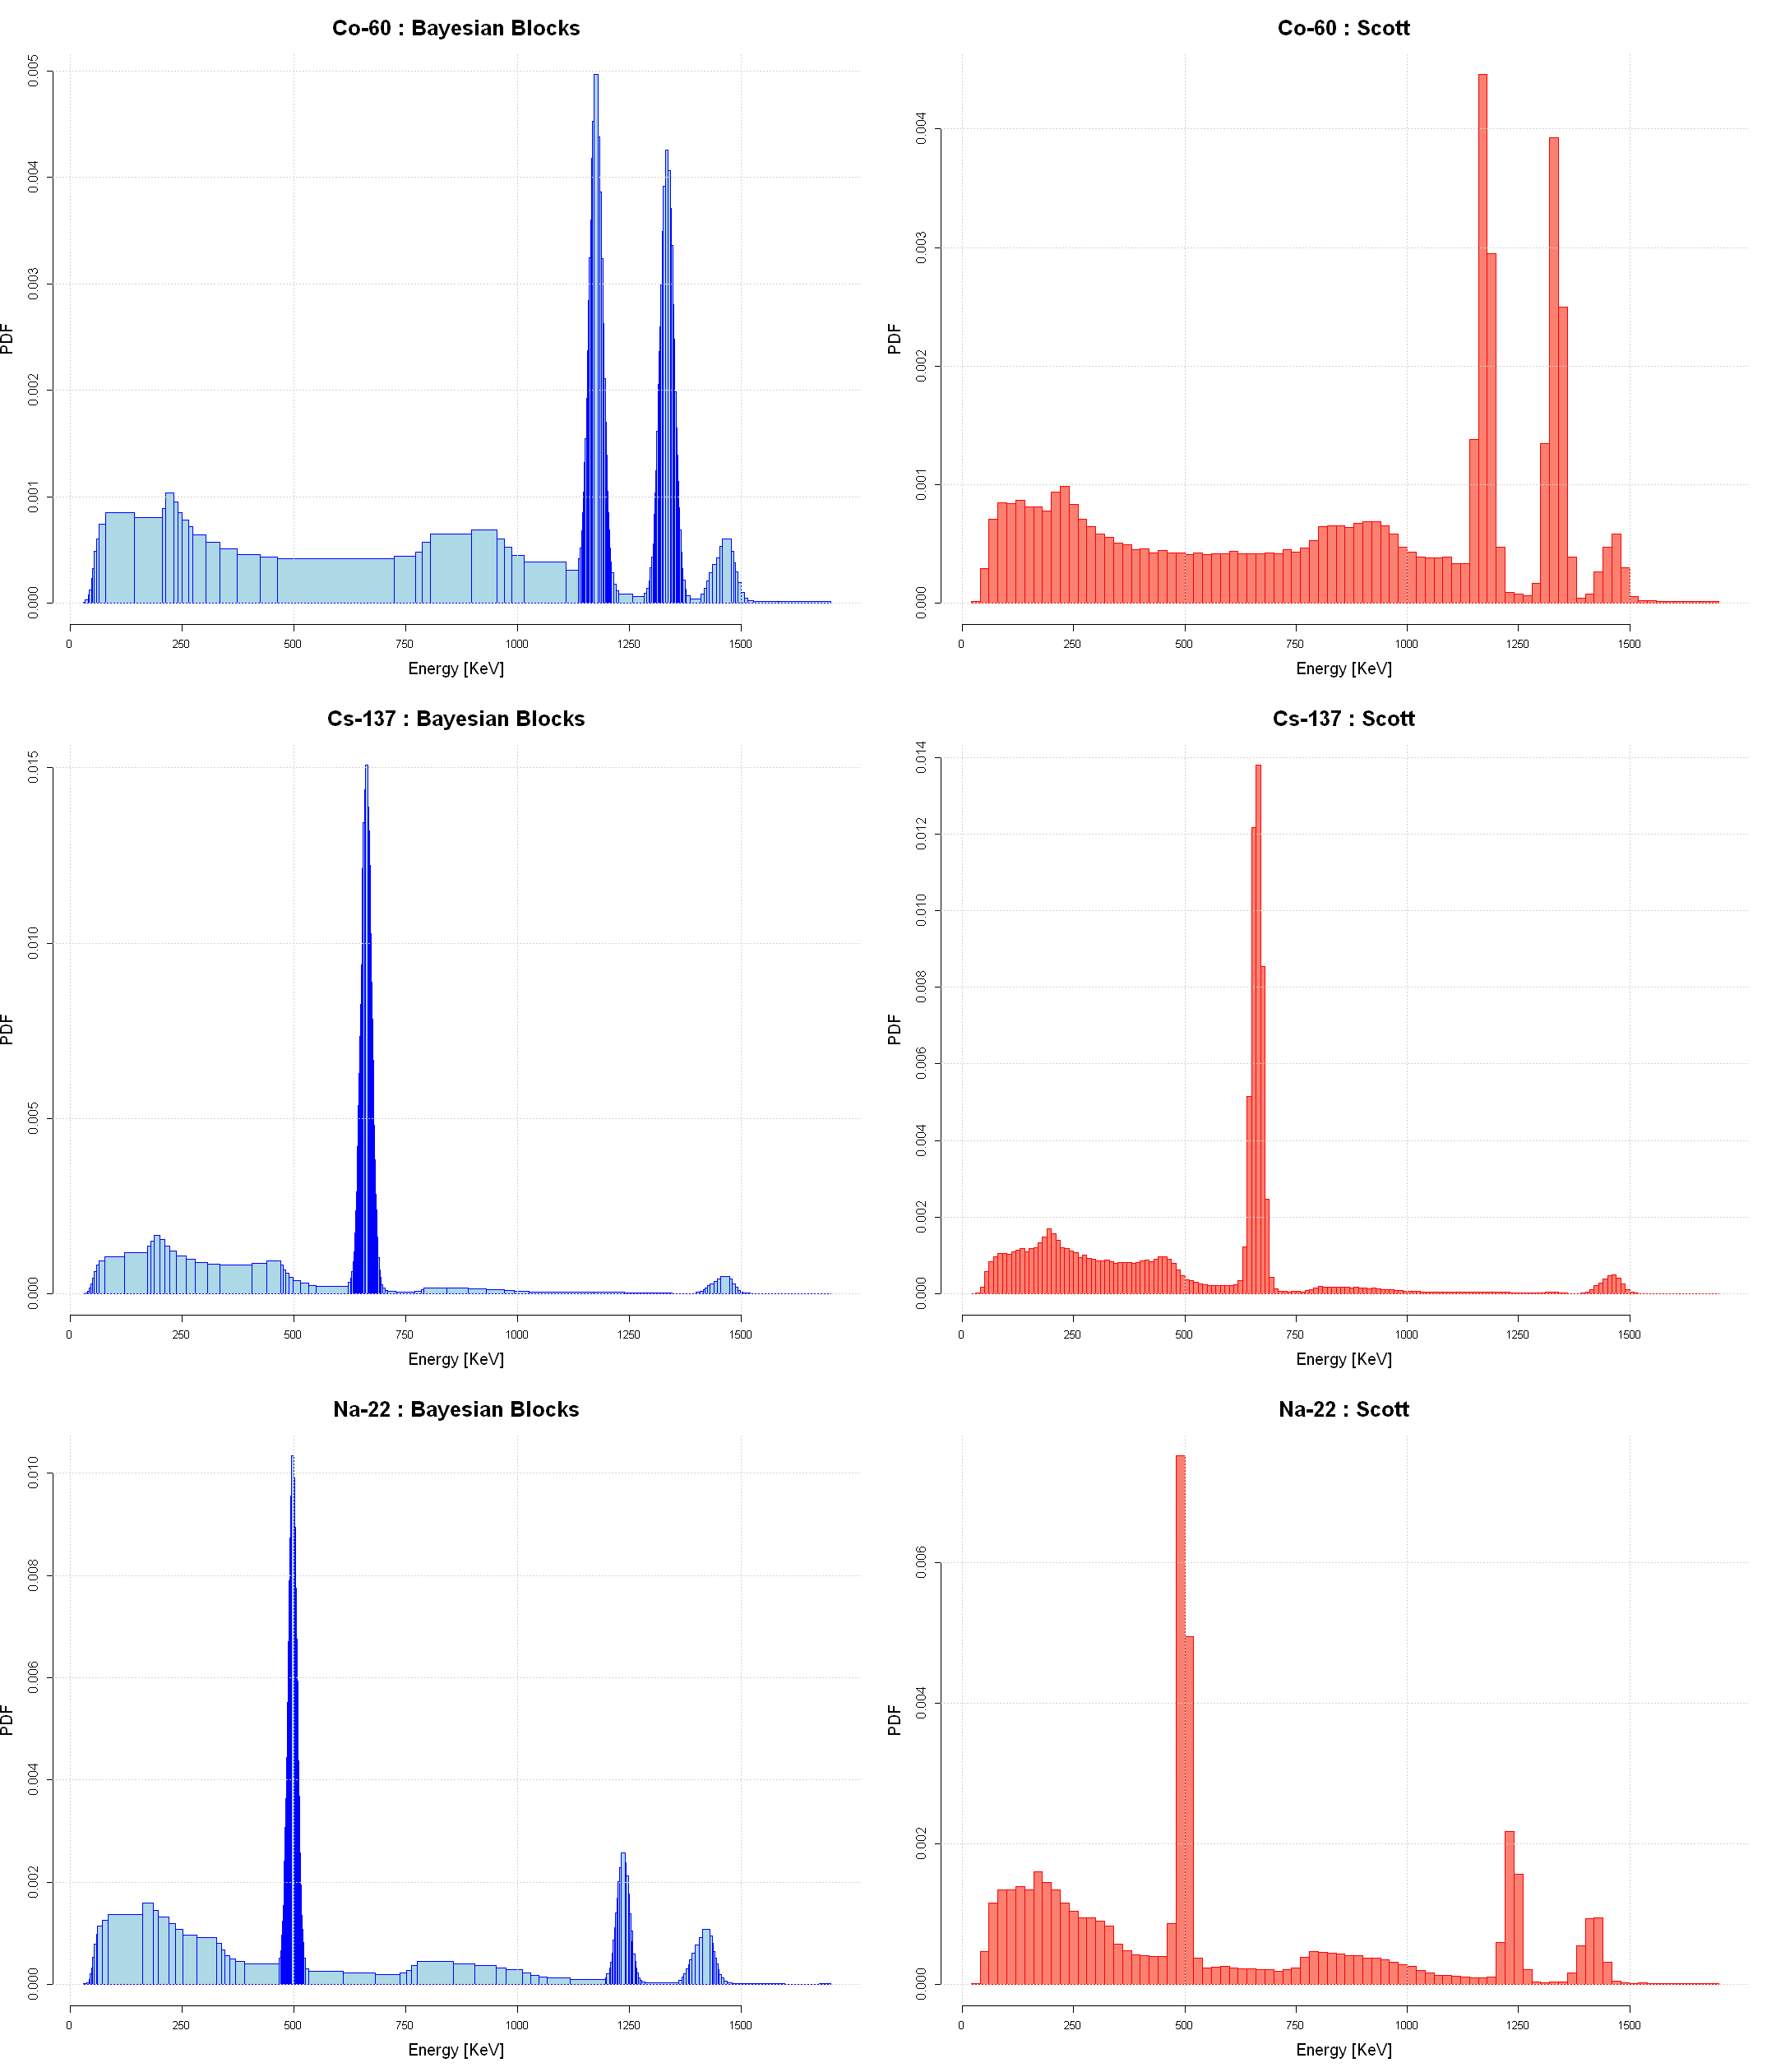

In [19]:
# plot results

plot_spectra <- function(data, breaks, source) {
     hist(data, breaks = breaks, col = "lightblue",  border = "blue",
          xlab = "Energy [KeV]", ylab = "PDF", main = paste(source, ": Bayesian Blocks"),
          xaxt = 'n', cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
     grid()
     axis(side = 1, at = seq(0, 1700, 250), labels = seq(0, 1700, 250))
     hist(data, breaks = "scott", col = "salmon",  border = "red", freq = FALSE,
          xlab = "Energy [KeV]", ylab = "PDF", main = paste(source, ": Scott"),
          xaxt = 'n', cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
     grid()
     axis(side = 1, at = seq(0, 1700, 250), labels = seq(0, 1700, 250))
}

par(mfrow = c(3, 2))
options(repr.plot.width = 18, repr.plot.height = 21)

plot_spectra(Co, breaks_Co, "Co-60")
plot_spectra(Cs, breaks_Cs, "Cs-137")
plot_spectra(Na, breaks_Na, "Na-22")

### 4.2. CMS Data <a name="app_cms"></a>

We will apply the algorithm to invariant mass distribution measured in dielectron events from 2010 CMS experiment. The invariant mass range is 2-110 GeV.

In [16]:
# load dataset
dielectron <- read_csv("Data/dielectron.csv", show_col_types = FALSE)
invMass <- na.omit(dielectron$M)

breaks_dielectron <- bayesian_blocks(invMass)

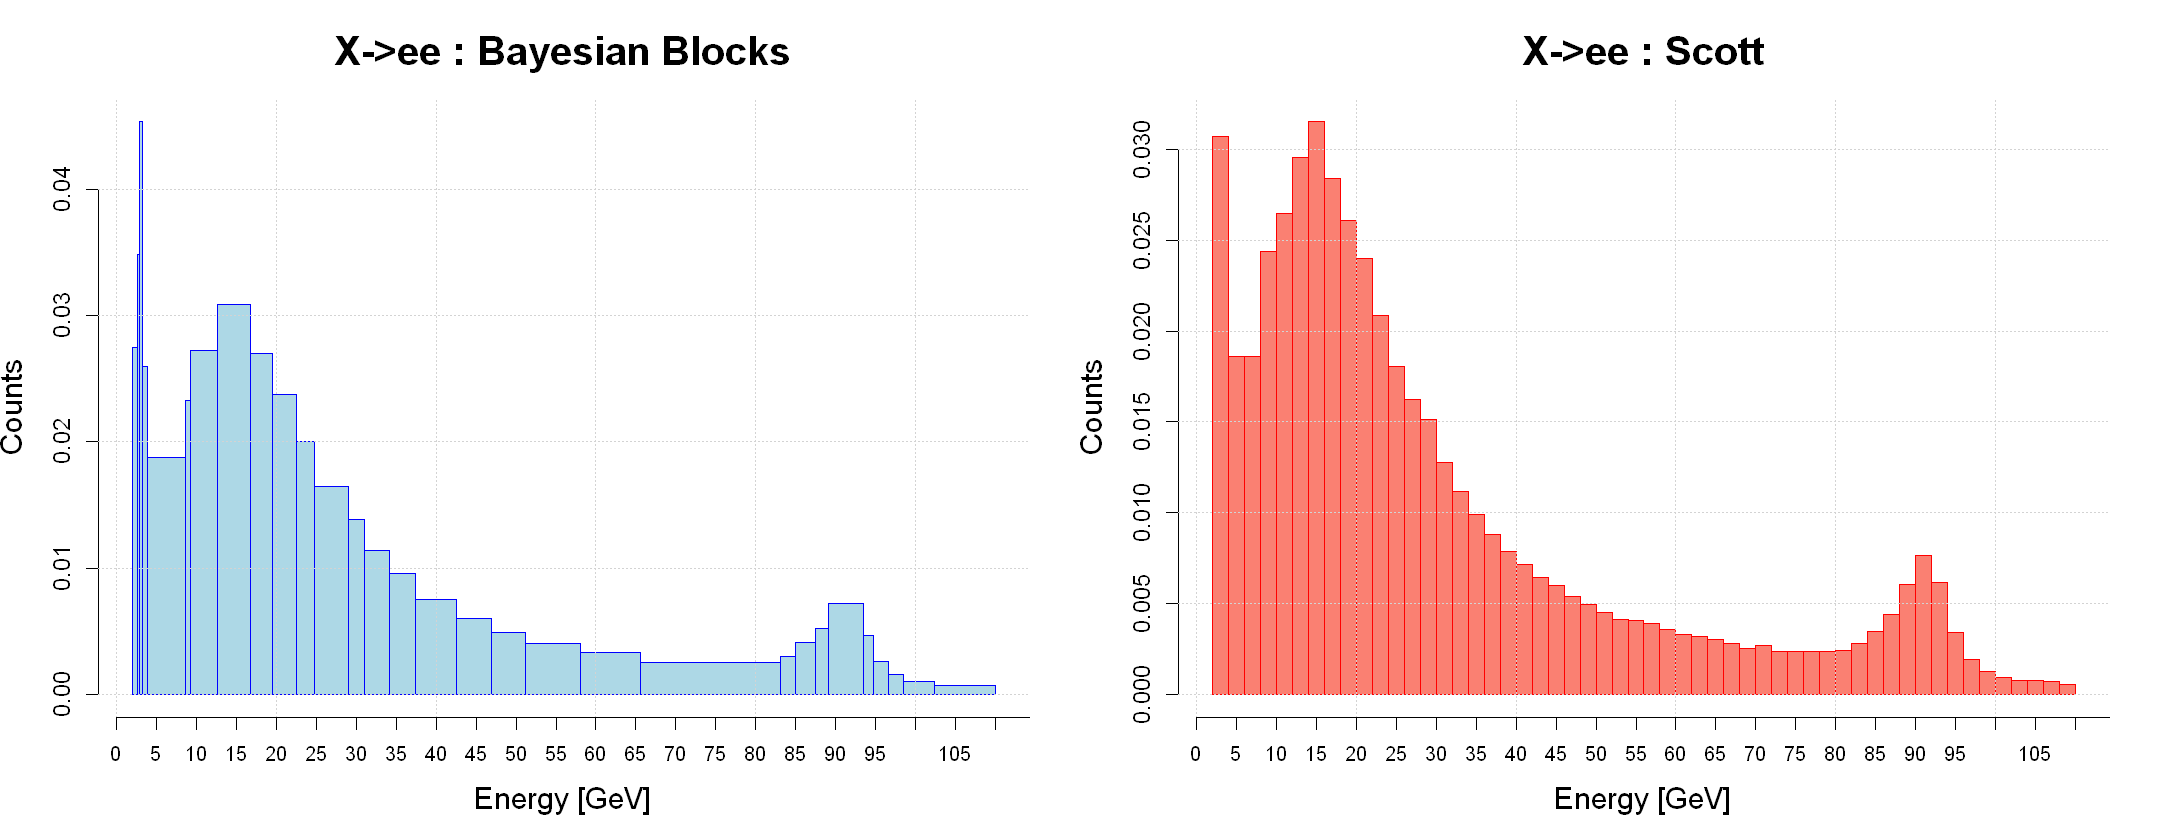

In [17]:
# plot results

plot_electrons <- function(data, breaks) {
     hist(data, breaks = breaks, col = "lightblue",  border = "blue",
          xlab = "Energy [GeV]", ylab = "Counts", main = "X->ee : Bayesian Blocks",
          xaxt = 'n', cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
     grid()
     axis(side = 1, at = seq(0, 150, 5), labels = seq(0, 150, 5))
     hist(data, breaks = "scott", col = "salmon",  border = "red", freq = FALSE,
          xlab = "Energy [GeV]", ylab = "Counts", main = "X->ee : Scott",
          xaxt = 'n', cex.lab = 1.5, cex.axis = 1.2, cex.main = 2)
     grid()
     axis(side = 1, at = seq(0, 150, 5), labels = seq(0, 150, 5))
}

par(mfrow = c(1, 2))
options(repr.plot.width = 18, repr.plot.height =  7)

plot_electrons(invMass, breaks_dielectron)

## 5. Bibliography <a name="bibliography"></a>

[1] J. D. Scargle *et al.*,
    Astrophys. J. **764**, 167 (2013)
    <a name="Scargle"></a>

[2] B. Pollack *et al.*,
    [arXiv:1708.008 10](https://arxiv.org/abs/1708.00810)
    <a name="Pollack"></a>

[3] D. W. Scott,
    Biometrika **66**, 605 (1979)
    <a name="Scott"></a>

[4] H. A. Sturges,
    Journal of the American Statistical Association  **21**, 65 (1926),
    https://doi.org/10.1080/01621459.1926.10502161.
    <a name="Sturges"></a>
                                             
[5] D. Freedman and P. Daiconis,
    Zeitschrift fur Wahrscheinlichkeitstheorie und verwandte Gebiete **57**, 453 (1981)
    <a name="FreedmanDiaconis"></a>
    
[6] M. Coram, 2002, PhD thesis, Stanford University
    <a name="Coram"></a>
